### Libraries used

In [3]:
# pip install efficientnet_pytorch

In [4]:
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import math
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

### Global Variables

In [5]:
kaggle_used = True

In [6]:
kaggle_path = "/kaggle/input" if kaggle_used else ""
root_folder = "finger-tip-videos"
csvs_folder = "IntelliHb-Dataset-20241214T125003Z-003/IntelliHb-Dataset"
train_videos_folder = "train-001/train"
test_videos_folder = "test-002/test"
train_file_name = "Train.csv"
test_file_name = "Test.csv"

### Create paths using above variables

In [7]:
train_test_csvs_path = os.path.join(kaggle_path, root_folder, csvs_folder)
train_csv_file_path = os.path.join(train_test_csvs_path,train_file_name)
test_csv_file_path = os.path.join(train_test_csvs_path,test_file_name)
train_videos_path = os.path.join(kaggle_path, root_folder, train_videos_folder)
test_videos_path = os.path.join(kaggle_path, root_folder, test_videos_folder)

### Check wheter paths are valid or not

In [8]:
print(train_test_csvs_path," -> " ,os.path.exists(train_test_csvs_path))
print(train_csv_file_path," -> " ,os.path.exists(train_csv_file_path))
print(test_csv_file_path," -> " ,os.path.exists(test_csv_file_path))
print(train_videos_path," -> " ,os.path.exists(train_videos_path))
print(test_videos_path," -> " ,os.path.exists(test_videos_path))

/kaggle/input/finger-tip-videos/IntelliHb-Dataset-20241214T125003Z-003/IntelliHb-Dataset  ->  True
/kaggle/input/finger-tip-videos/IntelliHb-Dataset-20241214T125003Z-003/IntelliHb-Dataset/Train.csv  ->  True
/kaggle/input/finger-tip-videos/IntelliHb-Dataset-20241214T125003Z-003/IntelliHb-Dataset/Test.csv  ->  True
/kaggle/input/finger-tip-videos/train-001/train  ->  True
/kaggle/input/finger-tip-videos/test-002/test  ->  True


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Models used

### Resnet-18

In [10]:
class VideoResNet18Regression(nn.Module):
    def __init__(self, num_frames, num_classes=1):
        super(VideoResNet18Regression, self).__init__()
        # Load a pre-trained ResNet-18 model
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the fully connected layer to match the regression output
        self.resnet.fc = nn.Identity()  # Remove the classification layer
        
        # Final regression layer
        self.regression_fc = nn.Linear(512 * num_frames, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.size()

        # Apply ResNet to each frame
        frame_features = []
        for i in range(num_frames):
            frame = x[:, i, :, :, :]  # Select the ith frame
            frame_feature = self.resnet(frame)  # Feature extraction for each frame
            frame_features.append(frame_feature)

        # Stack frame features along the temporal dimension
        frame_features = torch.stack(frame_features, dim=1)  # Shape: (batch_size, num_frames, 512)

        # Flatten the temporal dimension and apply a temporal FC layer
        frame_features = frame_features.view(batch_size, -1)  # Flatten (batch_size, num_frames * 512)

        # Final regression output
        output = self.regression_fc(frame_features)
        return output

### EfficientNet

In [11]:
class VideoEfficientNetRegression(nn.Module):
    def __init__(self, num_frames, num_classes=1, efficientnet_version='efficientnet-b0'):
        super(VideoEfficientNetRegression, self).__init__()
        
        # Load a pre-trained EfficientNet model
        self.efficientnet = EfficientNet.from_pretrained(efficientnet_version)
        
        # Modify the EfficientNet to output raw features
        self.efficientnet._fc = nn.Identity()  # Remove the classification layer

        # Final regression layer
        self.regression_fc = nn.Linear(1280* num_frames , num_classes)  # Adjust based on EfficientNet's output size (1280 for B0)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.size()

        # Apply EfficientNet to each frame
        frame_features = []
        for i in range(num_frames):
            frame = x[:, i, :, :, :]  # Select the ith frame
            frame_feature = self.efficientnet(frame)  # Feature extraction for each frame
            frame_features.append(frame_feature)

        # Stack frame features along the temporal dimension
        frame_features = torch.stack(frame_features, dim=1)  # Shape: (batch_size, num_frames, 1280)

        # Flatten the temporal dimension and apply a temporal FC layer
        frame_features = frame_features.view(batch_size, -1)  # Flatten (batch_size, num_frames * 1280)
        
        # Final regression output
        output = self.regression_fc(frame_features)
        return output

### VGG16

In [12]:
import torch
import torch.nn as nn
from torchvision import models

class VideoVGG16Regression(nn.Module):
    def __init__(self, num_frames, num_classes=1):
        super(VideoVGG16Regression, self).__init__()
        
        # Load a pre-trained VGG-16 model
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Modify the VGG-16 to output raw features
        self.vgg16.classifier = nn.Sequential(
            *list(self.vgg16.classifier.children())[:-1]
        )  # Remove the final classification layer, keeping the 4096-dimensional features

        # Final regression layer
        self.regression_fc = nn.Linear(4096 * num_frames, num_classes)  # Adjust for temporal stacking

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.size()

        # Apply VGG-16 to each frame
        frame_features = []
        for i in range(num_frames):
            frame = x[:, i, :, :, :]  # Select the ith frame
            frame_feature = self.vgg16(frame)  # Feature extraction for each frame
            frame_features.append(frame_feature)

        # Stack frame features along the temporal dimension
        frame_features = torch.stack(frame_features, dim=1)  # Shape: (batch_size, num_frames, 4096)

        # Flatten the temporal dimension
        frame_features = frame_features.view(batch_size, -1)  # Flatten (batch_size, num_frames * 4096)

        # Final regression output
        output = self.regression_fc(frame_features)
        return output

### CNN-LSTM Hybrid architecture

In [13]:
import torch
import torch.nn as nn
from torchvision import models

class VideoCNNLSTMRegression(nn.Module):
    def __init__(self, num_frames, num_classes=1):
        super(VideoCNNLSTMRegression, self).__init__()

        # CNN for feature extraction (using a smaller model for efficiency)
        self.cnn = models.resnet18(pretrained=True)  # Using ResNet18 as CNN backbone
        self.cnn.fc = nn.Identity()  # Remove the fully connected layer of ResNet18

        # LSTM layer to capture temporal information
        self.lstm = nn.LSTM(input_size=512,  # ResNet18 output size
                            hidden_size=512,
                            num_layers=2,
                            batch_first=True)

        # Final regression layer
        self.regression_fc = nn.Linear(512, num_classes)  # Output regression layer

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.size()

        # Extract features for each frame using CNN
        frame_features = []
        for i in range(num_frames):
            frame = x[:, i, :, :, :]  # Select the ith frame
            frame_feature = self.cnn(frame)  # Feature extraction for each frame
            frame_features.append(frame_feature)

        # Stack frame features along the temporal dimension
        frame_features = torch.stack(frame_features, dim=1)  # Shape: (batch_size, num_frames, 512)

        # Pass the frame features through the LSTM
        lstm_out, _ = self.lstm(frame_features)  # LSTM output (batch_size, num_frames, 512)

        # Use the output of the last time step from LSTM
        lstm_out = lstm_out[:, -1, :]  # (batch_size, 512)

        # Final regression output
        output = self.regression_fc(lstm_out)
        return output

### Training function

In [14]:
def train(model, num_epochs, train_loader, criterion, optimizer):

    training_loss = []
    model.to(device)
    # Simple Training Loop
    for epoch in range(num_epochs):
        print(f"epoch : {epoch+1}")
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for frames, labels in train_loader:
            frames = frames.to(device)  # Move frames to the device (GPU or CPU)
            labels = labels.to(device).float()  # Move labels to the device
    
            optimizer.zero_grad()  # Zero the gradients for the optimizer
    
            # Forward pass
            outputs = model(frames)
    
            # Compute loss
            loss = criterion(outputs, labels.view(-1, 1))  # Ensure labels are in correct shape for regression
    
            # Backward pass
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters
    
            running_loss += loss.item()  # Accumulate the loss

            del frames, labels, outputs, loss
            torch.cuda.empty_cache()
    
        # Print the average loss for this epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {math.sqrt(epoch_loss):.4f}")
        training_loss.append(math.sqrt(epoch_loss))
    return model, training_loss

### Testing loop

In [15]:
def test(model, test_loader, criterion):

    model.to(device)
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for frames, labels in test_loader:
            frames = frames.to(device)  # Move frames to the device (GPU or CPU)
            labels = labels.to(device).float()  # Move labels to the device
    
            # Forward pass
            outputs = model(frames)
    
            # Compute loss
            loss = criterion(outputs, labels.view(-1, 1))  # Ensure labels are in correct shape for regression
    
            running_loss += loss.item()  # Accumulate the loss

            del frames, labels, outputs, loss
            torch.cuda.empty_cache()
            
    del model
    torch.cuda.empty_cache()
    
    # Print the average loss for testing
    test_loss = running_loss / len(test_loader)
    print(f"Test Loss: {math.sqrt(test_loss):.4f}")
    return math.sqrt(test_loss)

### Dataset class for preprocessing and loading videos data

In [16]:
class VideoDataset(Dataset):
    def __init__(self, csv_file, videos_path, transform=None, num_frames=30):
        """
        Args:
            csv_file (str): Path to the CSV file with video paths and labels.
            transform (callable, optional): Optional transform to be applied on a video.
            num_frames (int): Number of frames to sample from each video (useful if videos have variable lengths).
            frame_size (tuple): Size to which each frame should be resized (default is (224, 224) for ResNet).
        """
        df = pd.read_csv(csv_file)  # Load video paths and labels
        df = df[df["VideoFile"] != "127.mp4"]
        self.video_df = df
        self.videos_path = videos_path
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_df)

    def __getitem__(self, idx):
        video_path = os.path.join(self.videos_path, self.video_df.iloc[idx, 4])
        label = float(self.video_df.iloc[idx, 3])
        
        frames = self._load_video(video_path)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        frames = torch.stack(frames)
        return frames, label

    def _load_video(self, video_path):
        """
        Loads and samples frames from a video file.
        """
        cap = cv2.VideoCapture(video_path)
        frames = []
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_indices = np.linspace(0, total_frames, self.num_frames + 2, dtype=int)
        frame_indices = frame_indices[1 : -1]
        for idx in frame_indices:

            frame = None
            index = idx
            ret = False
            
            while not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, index)
                ret, frame = cap.read()
                index+=1

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frames.append(frame)

        cap.release()
        return frames

In [17]:
def evaluate_models(config):

    test_loss = []
    model_name = []
    for key, val in config.items():
        
        model_name.append(config[key])

        print(f"EVALUATING : {key}")

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(config[key]["frame_size"]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        
        train_dataset = VideoDataset(csv_file = train_csv_file_path, videos_path = train_videos_path, transform=transform, num_frames=config[key]["num_frames"])
        train_loader = DataLoader(train_dataset, batch_size=config[key]["batch_size"], shuffle=True)
        
        test_dataset = VideoDataset(csv_file = test_csv_file_path, videos_path = test_videos_path, transform=transform, num_frames=config[key]["num_frames"])
        test_loader = DataLoader(test_dataset, batch_size=config[key]["batch_size"], shuffle=True)
        
        model = config[key]["model"](num_frames=config[key]["num_frames"], num_classes=1)
        
        criterion = config[key]["loss_function"]()
        optimizer = optim.AdamW(model.parameters(), lr=config[key]["learning_rate"])
        
        trained_model, training_loss = train(model, config[key]["epoch"], train_loader, criterion, optimizer)
        test_loss.append(test(trained_model, test_loader, criterion))

        # create training loss line plot for each model
        plt.plot(range(1, config[key]["epoch"]+1), 
                 training_loss, marker='o',  
                 linestyle='-', 
                 linewidth=2, 
                 markersize=6,
                 label=f"{key}")
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Losses for frame size of {config[key]["num_frames"]}')
    plt.grid(True) 
    plt.show()

    return test_loss

In [18]:
config = {
    "ResNet-18": {
        "model": VideoResNet18Regression,
        "epoch": 10,
        "num_frames":5,
        "frame_size": 224,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    },
    "EfficientNet": {
        "model": VideoEfficientNetRegression,
        "num_frames": 5,
        "epoch": 10,
        "frame_size": 224,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    },
    "VGG16": {
        "model": VideoVGG16Regression,
        "num_frames": 5,
        "epoch": 10,
        "frame_size": 224,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    },
    "CNN-LSTM": {
        "model": VideoCNNLSTMRegression,
        "num_frames": 5,
        "epoch": 10,
        "frame_size": 224,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    }
}

In [19]:
# test_losses = evaluate_models(config)

In [20]:
def evaluate_models_for_custom_frames(config, frame):

    models_used = list(config.keys())
    
    for k,v in config.items():
        config[k]["num_frames"] = frame
        config[k]["batch_size"] = 4
    
    print(f"running evaluation for {frame} frames")
    test_losses = evaluate_models(config)
    
    print(f"FRAME : {frame}")
    print(f"MODELS USED :{models_used}")
    print(f"TEST LOSSES : {test_losses}")

running evaluation for 5 frames
EVALUATING : ResNet-18


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s] 


epoch : 1
Epoch [1/10], Training Loss: 5.7754
epoch : 2
Epoch [2/10], Training Loss: 2.4935
epoch : 3
Epoch [3/10], Training Loss: 1.4844
epoch : 4
Epoch [4/10], Training Loss: 1.2123
epoch : 5
Epoch [5/10], Training Loss: 1.0113
epoch : 6
Epoch [6/10], Training Loss: 1.0029
epoch : 7
Epoch [7/10], Training Loss: 0.8015
epoch : 8
Epoch [8/10], Training Loss: 0.8154
epoch : 9
Epoch [9/10], Training Loss: 1.0596
epoch : 10
Epoch [10/10], Training Loss: 0.6607
Test Loss: 1.8168
EVALUATING : EfficientNet


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 152MB/s]


Loaded pretrained weights for efficientnet-b0
epoch : 1
Epoch [1/10], Training Loss: 7.6866
epoch : 2
Epoch [2/10], Training Loss: 6.4582
epoch : 3
Epoch [3/10], Training Loss: 4.8552
epoch : 4
Epoch [4/10], Training Loss: 2.8548
epoch : 5
Epoch [5/10], Training Loss: 1.5711
epoch : 6
Epoch [6/10], Training Loss: 1.4684
epoch : 7
Epoch [7/10], Training Loss: 1.2634
epoch : 8
Epoch [8/10], Training Loss: 1.2622
epoch : 9
Epoch [9/10], Training Loss: 1.1452
epoch : 10
Epoch [10/10], Training Loss: 1.0903
Test Loss: 2.2176
EVALUATING : VGG16


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 199MB/s] 


epoch : 1
Epoch [1/10], Training Loss: 4.1366
epoch : 2
Epoch [2/10], Training Loss: 1.6791
epoch : 3
Epoch [3/10], Training Loss: 1.6774
epoch : 4
Epoch [4/10], Training Loss: 1.6051
epoch : 5
Epoch [5/10], Training Loss: 1.5872
epoch : 6
Epoch [6/10], Training Loss: 1.8144
epoch : 7
Epoch [7/10], Training Loss: 1.5901
epoch : 8
Epoch [8/10], Training Loss: 1.5990
epoch : 9
Epoch [9/10], Training Loss: 1.6037
epoch : 10
Epoch [10/10], Training Loss: 1.5137
Test Loss: 1.4006
EVALUATING : CNN-LSTM


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch : 1
Epoch [1/10], Training Loss: 6.9683
epoch : 2
Epoch [2/10], Training Loss: 2.6483
epoch : 3
Epoch [3/10], Training Loss: 1.7376
epoch : 4
Epoch [4/10], Training Loss: 1.5306
epoch : 5
Epoch [5/10], Training Loss: 1.4984
epoch : 6
Epoch [6/10], Training Loss: 1.4644
epoch : 7
Epoch [7/10], Training Loss: 1.3885
epoch : 8
Epoch [8/10], Training Loss: 1.4529
epoch : 9
Epoch [9/10], Training Loss: 1.3817
epoch : 10
Epoch [10/10], Training Loss: 1.3629
Test Loss: 1.4787


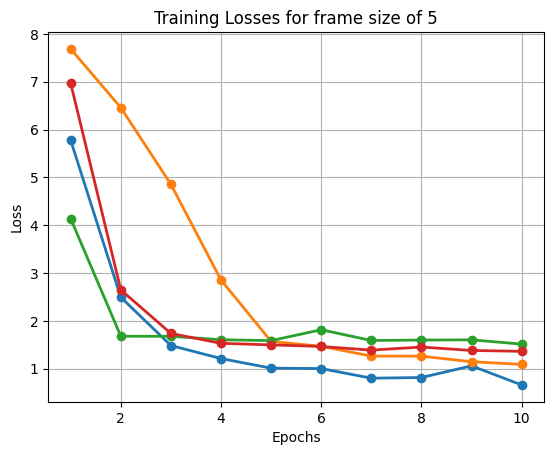

FRAME : 5
MODELS USED :['ResNet-18', 'EfficientNet', 'VGG16', 'CNN-LSTM']
TEST LOSSES : [1.816756249619277, 2.2176432535654387, 1.4005965396691011, 1.4787281946846298]


In [20]:
evaluate_models_for_custom_frames(config, 5)

running evaluation for 10 frames
EVALUATING : ResNet-18


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s] 


epoch : 1
Epoch [1/10], Training Loss: 4.5138
epoch : 2
Epoch [2/10], Training Loss: 1.6197
epoch : 3
Epoch [3/10], Training Loss: 1.4770
epoch : 4
Epoch [4/10], Training Loss: 1.2238
epoch : 5
Epoch [5/10], Training Loss: 1.3110
epoch : 6
Epoch [6/10], Training Loss: 1.1040
epoch : 7
Epoch [7/10], Training Loss: 1.0441
epoch : 8
Epoch [8/10], Training Loss: 1.0010
epoch : 9
Epoch [9/10], Training Loss: 0.9659
epoch : 10
Epoch [10/10], Training Loss: 1.0393
Test Loss: 1.4331
EVALUATING : EfficientNet


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 178MB/s]


Loaded pretrained weights for efficientnet-b0
epoch : 1
Epoch [1/10], Training Loss: 6.0518
epoch : 2
Epoch [2/10], Training Loss: 1.9187
epoch : 3
Epoch [3/10], Training Loss: 1.6545
epoch : 4
Epoch [4/10], Training Loss: 1.5036
epoch : 5
Epoch [5/10], Training Loss: 1.3881
epoch : 6
Epoch [6/10], Training Loss: 1.3331
epoch : 7
Epoch [7/10], Training Loss: 1.1995
epoch : 8
Epoch [8/10], Training Loss: 1.2291
epoch : 9
Epoch [9/10], Training Loss: 1.1184
epoch : 10
Epoch [10/10], Training Loss: 1.1215
Test Loss: 2.7494
EVALUATING : VGG16


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 213MB/s]  


epoch : 1
Epoch [1/10], Training Loss: 3.2460
epoch : 2
Epoch [2/10], Training Loss: 2.0912
epoch : 3
Epoch [3/10], Training Loss: 2.0381
epoch : 4
Epoch [4/10], Training Loss: 1.7099
epoch : 5
Epoch [5/10], Training Loss: 1.6324
epoch : 6
Epoch [6/10], Training Loss: 1.5529
epoch : 7
Epoch [7/10], Training Loss: 1.5880
epoch : 8
Epoch [8/10], Training Loss: 1.7353
epoch : 9
Epoch [9/10], Training Loss: 1.5479
epoch : 10
Epoch [10/10], Training Loss: 1.5104
Test Loss: 2.0165
EVALUATING : CNN-LSTM


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch : 1
Epoch [1/10], Training Loss: 4.9562
epoch : 2
Epoch [2/10], Training Loss: 1.5223
epoch : 3
Epoch [3/10], Training Loss: 1.5955
epoch : 4
Epoch [4/10], Training Loss: 1.5336
epoch : 5
Epoch [5/10], Training Loss: 1.5636
epoch : 6
Epoch [6/10], Training Loss: 1.4388
epoch : 7
Epoch [7/10], Training Loss: 1.4984
epoch : 8
Epoch [8/10], Training Loss: 1.5422
epoch : 9
Epoch [9/10], Training Loss: 1.5512
epoch : 10
Epoch [10/10], Training Loss: 1.4884
Test Loss: 1.5606


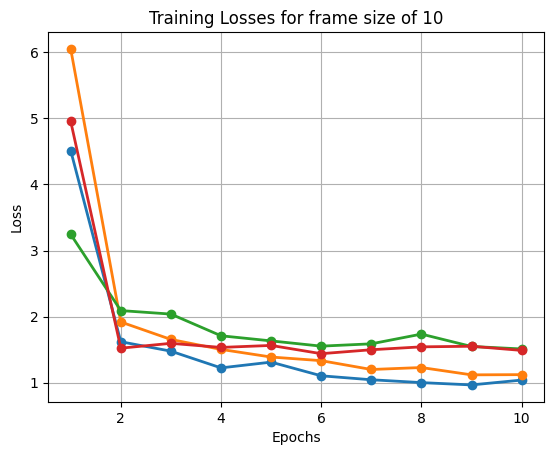

FRAME : 10
MODELS USED :['ResNet-18', 'EfficientNet', 'VGG16', 'CNN-LSTM']
TEST LOSSES : [1.4331037921018395, 2.749408217395651, 2.016450054213155, 1.5605638023289141]


In [21]:
evaluate_models_for_custom_frames(config, 10)

running evaluation for 15 frames
EVALUATING : ResNet-18


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s] 


epoch : 1
Epoch [1/10], Training Loss: 4.1800
epoch : 2
Epoch [2/10], Training Loss: 1.8821
epoch : 3
Epoch [3/10], Training Loss: 1.2788
epoch : 4
Epoch [4/10], Training Loss: 1.0803
epoch : 5
Epoch [5/10], Training Loss: 1.0325
epoch : 6
Epoch [6/10], Training Loss: 0.7511
epoch : 7
Epoch [7/10], Training Loss: 0.8538
epoch : 8
Epoch [8/10], Training Loss: 0.8122
epoch : 9
Epoch [9/10], Training Loss: 0.7414
epoch : 10
Epoch [10/10], Training Loss: 0.7018
Test Loss: 1.4226
EVALUATING : EfficientNet


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 149MB/s]


Loaded pretrained weights for efficientnet-b0
epoch : 1
Epoch [1/10], Training Loss: 6.6972
epoch : 2
Epoch [2/10], Training Loss: 3.3574
epoch : 3
Epoch [3/10], Training Loss: 1.7990
epoch : 4
Epoch [4/10], Training Loss: 1.5063
epoch : 5
Epoch [5/10], Training Loss: 1.3304
epoch : 6
Epoch [6/10], Training Loss: 1.3091
epoch : 7
Epoch [7/10], Training Loss: 1.2871
epoch : 8
Epoch [8/10], Training Loss: 1.2392
epoch : 9
Epoch [9/10], Training Loss: 1.1322
epoch : 10
Epoch [10/10], Training Loss: 1.0715
Test Loss: 1.5185
EVALUATING : VGG16


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 212MB/s] 


epoch : 1
Epoch [1/10], Training Loss: 4.8435
epoch : 2
Epoch [2/10], Training Loss: 1.7615
epoch : 3
Epoch [3/10], Training Loss: 1.8994
epoch : 4
Epoch [4/10], Training Loss: 2.0523
epoch : 5
Epoch [5/10], Training Loss: 1.5017
epoch : 6
Epoch [6/10], Training Loss: 1.5573
epoch : 7
Epoch [7/10], Training Loss: 1.4410
epoch : 8
Epoch [8/10], Training Loss: 1.6322
epoch : 9
Epoch [9/10], Training Loss: 1.4449
epoch : 10
Epoch [10/10], Training Loss: 1.4313
Test Loss: 1.7435
EVALUATING : CNN-LSTM


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch : 1
Epoch [1/10], Training Loss: 6.5054
epoch : 2
Epoch [2/10], Training Loss: 2.1869
epoch : 3
Epoch [3/10], Training Loss: 1.7048
epoch : 4
Epoch [4/10], Training Loss: 1.5636
epoch : 5
Epoch [5/10], Training Loss: 1.5146
epoch : 6
Epoch [6/10], Training Loss: 1.4425
epoch : 7
Epoch [7/10], Training Loss: 1.3979
epoch : 8
Epoch [8/10], Training Loss: 1.3458
epoch : 9
Epoch [9/10], Training Loss: 1.4067
epoch : 10
Epoch [10/10], Training Loss: 1.3284
Test Loss: 1.8984


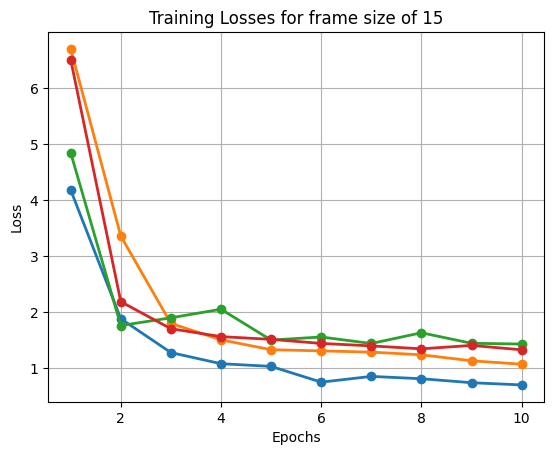

FRAME : 15
MODELS USED :['ResNet-18', 'EfficientNet', 'VGG16', 'CNN-LSTM']
TEST LOSSES : [1.4225667381721254, 1.5184624156332653, 1.7434700833503363, 1.8983792896529985]


In [22]:
evaluate_models_for_custom_frames(config, 15)

### Config File

In [ ]:
config = {
    
    "EfficientNet": {
        "model": VideoEfficientNetRegression,
        "num_frames": 5,
        "epoch": 10,
        "frame_size": 224,
        "batch_size": 4,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    },
    "VGG16": {
        "model": VideoVGG16Regression,
        "num_frames": 5,
        "epoch": 10,
        "frame_size": 224,
        "batch_size": 4,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    },
    "CNN-LSTM": {
        "model": VideoCNNLSTMRegression,
        "num_frames": 5,
        "epoch": 10,
        "frame_size": 224,
        "batch_size": 4,
        "learning_rate": 1e-4,
        "loss_function": nn.MSELoss
    }
}

### Training loss for 5 frames

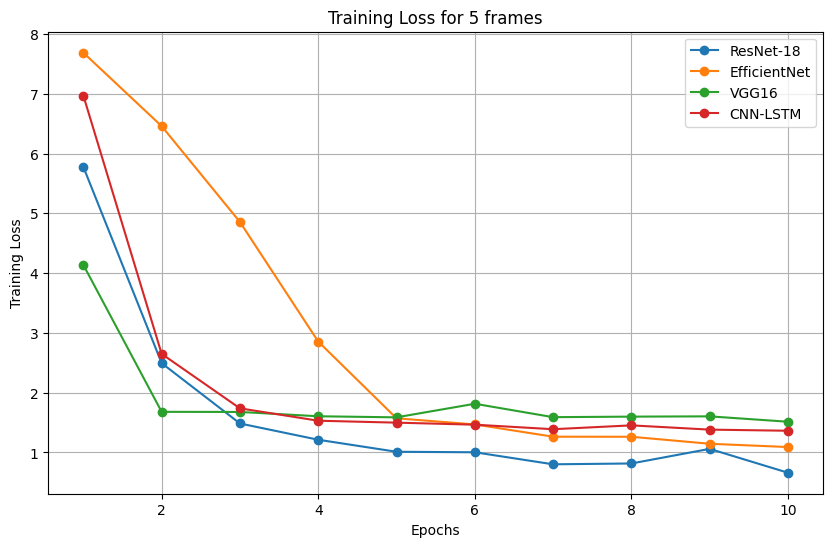

In [1]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = list(range(1, 11))

# Training losses for each model
resnet18_losses = [5.7754, 2.4935, 1.4844, 1.2123, 1.0113, 1.0029, 0.8015, 0.8154, 1.0596, 0.6607]
efficientnet_losses = [7.6866, 6.4582, 4.8552, 2.8548, 1.5711, 1.4684, 1.2634, 1.2622, 1.1452, 1.0903]
vgg16_losses = [4.1366, 1.6791, 1.6774, 1.6051, 1.5872, 1.8144, 1.5901, 1.5990, 1.6037, 1.5137]
cnn_lstm_losses = [6.9683, 2.6483, 1.7376, 1.5306, 1.4984, 1.4644, 1.3885, 1.4529, 1.3817, 1.3629]

# Plot each model's training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, resnet18_losses, marker='o', label='ResNet-18')
plt.plot(epochs, efficientnet_losses, marker='o', label='EfficientNet')
plt.plot(epochs, vgg16_losses, marker='o', label='VGG16')
plt.plot(epochs, cnn_lstm_losses, marker='o', label='CNN-LSTM')

# Add titles and labels
plt.title('Training Loss for 5 frames')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

### Training loss for 10 frames


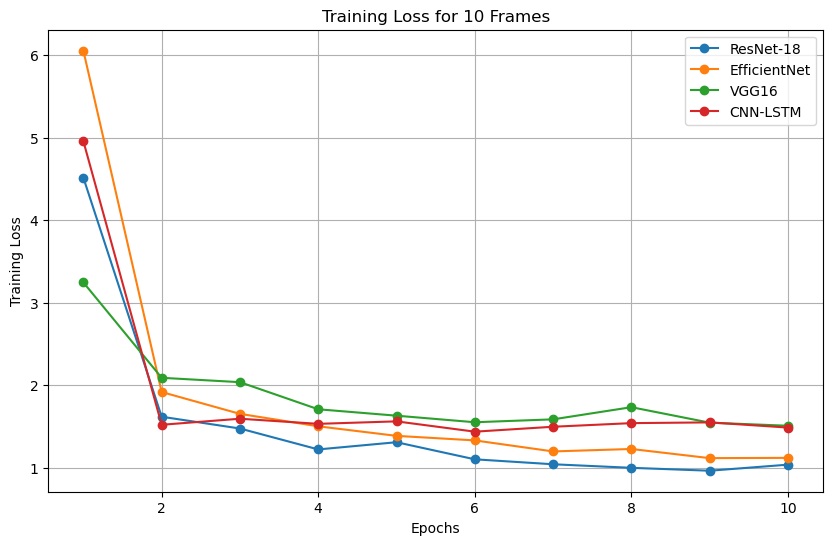

In [1]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

resnet18_losses = [4.5138, 1.6197, 1.4770, 1.2238, 1.3110, 1.1040, 1.0441, 1.0010, 0.9659, 1.0393]
efficientnet_losses = [6.0518, 1.9187, 1.6545, 1.5036, 1.3881, 1.3331, 1.1995, 1.2291, 1.1184, 1.1215]
vgg16_losses = [3.2460, 2.0912, 2.0381, 1.7099, 1.6324, 1.5529, 1.5880, 1.7353, 1.5479, 1.5104]
cnn_lstm_losses = [4.9562, 1.5223, 1.5955, 1.5336, 1.5636, 1.4388, 1.4984, 1.5422, 1.5512, 1.4884]


# Plot each model's training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, resnet18_losses, marker='o', label='ResNet-18')
plt.plot(epochs, efficientnet_losses, marker='o', label='EfficientNet')
plt.plot(epochs, vgg16_losses, marker='o', label='VGG16')
plt.plot(epochs, cnn_lstm_losses, marker='o', label='CNN-LSTM')

# Add titles and labels
plt.title('Training Loss for 10 Frames')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

### Training loss for 15 Frames

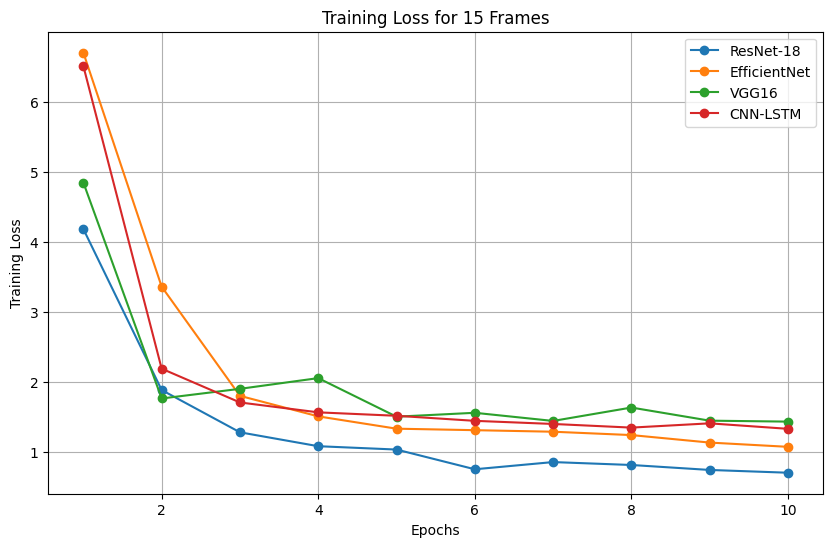

In [3]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = list(range(1, 11))

# Training losses for each model (15 frames)
resnet18_losses = [4.1800, 1.8821, 1.2788, 1.0803, 1.0325, 0.7511, 0.8538, 0.8122, 0.7414, 0.7018]
efficientnet_losses = [6.6972, 3.3574, 1.7990, 1.5063, 1.3304, 1.3091, 1.2871, 1.2392, 1.1322, 1.0715]
vgg16_losses = [4.8435, 1.7615, 1.8994, 2.0523, 1.5017, 1.5573, 1.4410, 1.6322, 1.4449, 1.4313]
cnn_lstm_losses = [6.5054, 2.1869, 1.7048, 1.5636, 1.5146, 1.4425, 1.3979, 1.3458, 1.4067, 1.3284]

# Plot each model's training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, resnet18_losses, marker='o', label='ResNet-18')
plt.plot(epochs, efficientnet_losses, marker='o', label='EfficientNet')
plt.plot(epochs, vgg16_losses, marker='o', label='VGG16')
plt.plot(epochs, cnn_lstm_losses, marker='o', label='CNN-LSTM')

# Add titles and labels
plt.title('Training Loss for 15 Frames')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

### Test Results

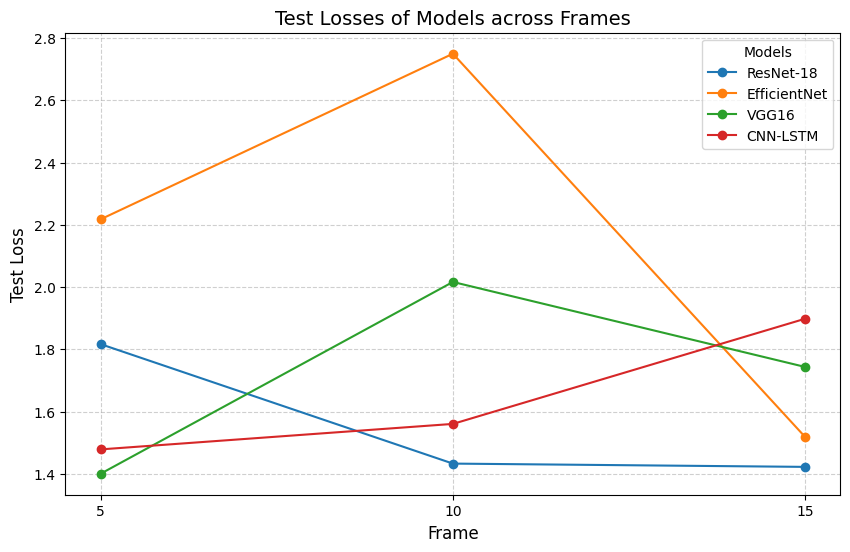

In [24]:
import matplotlib.pyplot as plt

# Data
frames = [5, 10, 15]
models = ['ResNet-18', 'EfficientNet', 'VGG16', 'CNN-LSTM']
losses = {
    'ResNet-18': [1.816756249619277, 1.4331037921018395, 1.4225667381721254],
    'EfficientNet': [2.2176432535654387, 2.749408217395651, 1.5184624156332653],
    'VGG16': [1.4005965396691011, 2.016450054213155, 1.7434700833503363],
    'CNN-LSTM': [1.4787281946846298, 1.5605638023289141, 1.8983792896529985]
}

# Plotting
plt.figure(figsize=(10, 6))

for model, loss in losses.items():
    plt.plot(frames, loss, marker='o', label=model)

# Customization
plt.title("Test Losses of Models across Frames", fontsize=14)
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Test Loss", fontsize=12)
plt.xticks(frames, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Models", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Display
plt.show()